In [1]:
# ROBERT HEETER
# ELEC 378 Machine Learning
# 24 March 2023

# PROBLEM SET 8


y_test digit labels:
[8 9 8 8 9 9 8 9 8 9 8 9 8 8 9 8 9 8 8 9 9 8 9 9 9 8 9 8 8 9 9 8 9 8 9 9 9
 8 9 8 8 9 8 9 8 9 9 9 8 9 8 8 9 9 8 9 8 9 8 9 8 8 9 8 9 8]

y_approx digit labels from logistic regression:
[8 9 8 8 9 9 8 9 8 9 8 9 8 8 9 8 9 8 9 9 9 8 9 9 9 8 9 8 8 9 9 8 9 8 9 8 9
 8 9 8 8 9 8 9 8 9 9 9 8 9 8 8 9 9 8 9 8 9 8 9 8 8 9 8 9 8]

error indices:
[18 35]

error rate from test data:
3.0303030303030303%

ERROR 1:
actual label (y_test) = 8
predicted label from logistic regression (y_approx) = 9
model probability of 8 = 0.25486973286795456
model probability of 9 = 0.7451302671320454


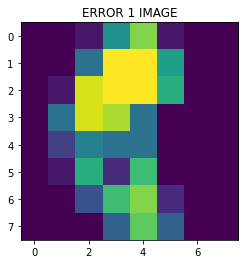


ERROR 2:
actual label (y_test) = 9
predicted label from logistic regression (y_approx) = 8
model probability of 8 = 0.9989519838330652
model probability of 9 = 0.001048016166934838


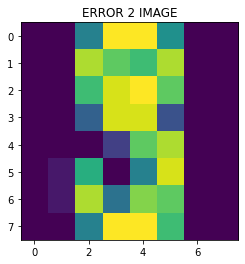

In [2]:
# PROBLEM 2

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression

# load digits
digits = load_digits()

# select 8's and 9's; save first 288 for training and remaining for testing
all_X = digits['data']
all_y = digits['target']

idx_89 = np.where((all_y==9) | (all_y==8))[0]

X = all_X[idx_89,:]
y = all_y[idx_89]

X_train = X[:288]
X_test = X[288:]

y_train = y[:288]
y_test = y[288:]

# logistic regression
log = LogisticRegression(penalty='l2', tol=0.0001, fit_intercept=True, max_iter=200).fit(X_train, y_train)
y_approx = log.predict(X_test)
y_approx_probabilities = log.predict_proba(X_test)

# find errors and display
idx_errors = np.where((y_test-y_approx) != 0)[0]

print(f'y_test digit labels:\n{y_test}')
print(f'\ny_approx digit labels from logistic regression:\n{y_approx}')

print(f'\nerror indices:\n{idx_errors}')

error_rate = len(idx_errors)/len(y_test)
print(f'\nerror rate from test data:\n{100*error_rate}%')

print(f'\nERROR 1:\nactual label (y_test) = {y_test[idx_errors[0]]}')
print(f'predicted label from logistic regression (y_approx) = {y_approx[idx_errors[0]]}')
print(f'model probability of 8 = {y_approx_probabilities[idx_errors[0]][0]}')
print(f'model probability of 9 = {y_approx_probabilities[idx_errors[0]][1]}')

# error 1 image
index = idx_errors[0]
plt.imshow(X_test[index].reshape((8,8)))
plt.title('ERROR 1 IMAGE')
plt.show()

print(f'\nERROR 2:\nactual label (y_test) = {y_test[idx_errors[1]]}')
print(f'predicted label from logistic regression (y_approx) = {y_approx[idx_errors[1]]}')
print(f'model probability of 8 = {y_approx_probabilities[idx_errors[1]][0]}')
print(f'model probability of 9 = {y_approx_probabilities[idx_errors[1]][1]}')

# error 2 image
index = idx_errors[1]
plt.imshow(X_test[index].reshape((8,8)))
plt.title('ERROR 2 IMAGE')
plt.show()


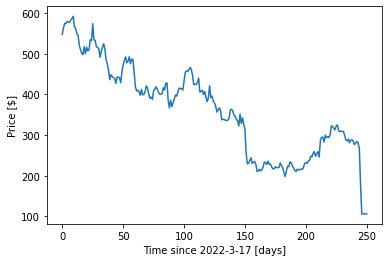

In [3]:
# PROBLEM 3

import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
from scipy.linalg import lstsq

data = yf.Ticker('SIVB')
stock = data.history(period='1d', start='2022-3-17', end='2023-3-17')
price = stock['Open'].values

plt.plot(price)
plt.xlabel('Time since 2022-3-17 [days]')
plt.ylabel('Price [$]')
plt.show()

In [4]:
# constructing the Toeplitz data matrix (from LMS slides page 7)
p = 10
toeplitz_indices = np.arange(p-1,-1,-1)[None,:] + np.arange(len(price)-p)[:,None]
prediction_indices = np.arange(p,len(price))

X = price[toeplitz_indices]
y = price[prediction_indices]

Wiener filter via LS RMS error = $14.44


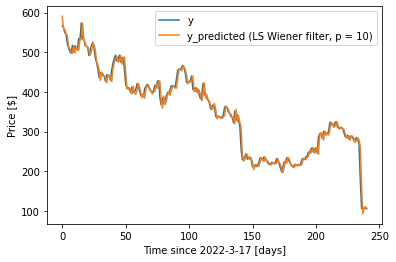

In [5]:
# predict y from X using the Wiener filter found via least squares

wiener_filter_LS = np.linalg.inv(X.T @ X) @ X.T @ y
y_predicted_LS = X @ wiener_filter_LS

error_LS = y - y_predicted_LS
RMSE_error_LS = np.average(np.square(error_LS))**(1/2)
print(f'Wiener filter via LS RMS error = ${np.round(RMSE_error_LS,2)}')

plt.plot(y)
plt.plot(y_predicted_LS)
plt.legend(['y',f'y_predicted (LS Wiener filter, p = {p})'])
plt.xlabel('Time since 2022-3-17 [days]')
plt.ylabel('Price [$]')
plt.show()

Wiener filter via LMS RMS error = $54.85


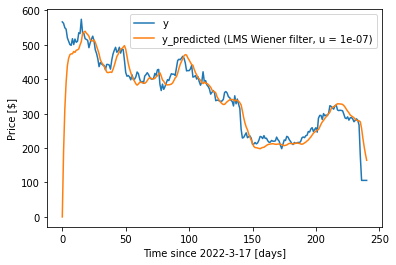

In [6]:
# predict y from X using the Wiener filter estimated adaptively via LMS

# initialize the weights and output
wiener_filter_LMS = np.zeros(p)
y_predicted_LMS = np.zeros(y.shape)
u = 0.0000001

for i in range(toeplitz_indices.shape[0]):
    # predict the output given the current estimate of the wiener filter
    y_predicted_LMS[i] = np.dot(X[i],wiener_filter_LMS)
    
    # use the prediction error to update the wiener filter estimate
    wiener_filter_LMS = wiener_filter_LMS + u*X[i]*(y[i] - y_predicted_LMS[i])

error_LMS = y - y_predicted_LMS
RMSE_error_LMS = np.average(np.square(error_LMS))**(1/2)
print(f'Wiener filter via LMS RMS error = ${np.round(RMSE_error_LMS,2)}')

plt.plot(y)
plt.plot(y_predicted_LMS)
plt.legend(['y',f'y_predicted (LMS Wiener filter, u = {u})'])
plt.xlabel('Time since 2022-3-17 [days]')
plt.ylabel('Price [$]')
plt.show()